In [ ]:
pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.4 MB/s eta 0:00:00


In [ ]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [ ]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [ ]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

# extra code – this cell displays an animation of one episode

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v0", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

In [ ]:
import gymnasium as gym
env = gym.make("CartPole-v0", render_mode = "rgb_array")

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [ ]:
import numpy as np
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(8, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

In [ ]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN

In [ ]:
from collections import deque

replay_buffer = deque(maxlen=2000)

In [ ]:
# extra code – A basic circular buffer implementation

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

In [ ]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

In [ ]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [ ]:
# extra code – for reproducibility, and to generate the next figure
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

In [ ]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
for episode in range(600):
    total_reward = 0
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        total_reward += reward
        if done or truncated:
            break

    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(total_reward)
    if total_reward >= best_score:
        best_weights = model.get_weights()
        best_score = total_reward

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)  # extra code – restores the best model weights

Episode: 52, Steps: 19, eps: 0.898

Episode: 600, Steps: 94, eps: 0.010

In [ ]:
def play_best():
  action = model.predict

In [ ]:
show_one_episode(epsilon_greedy_policy)

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


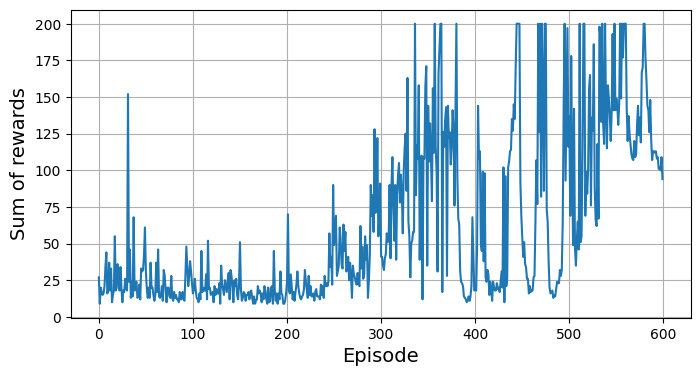

In [ ]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()